In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
def normalize(x):
    mean = np.mean(x)
    std = np.std(x)
    x_norm = (x - mean) / std
    return x_norm

def standardize(x):
    m = max(x)
    return x/m

def replace_outliers_zscore(x, threshold=3):
    z = np.abs((x - np.mean(x)) / np.std(x))
    x_filtered = x.copy()
    x_filtered[z >= threshold] = np.median(x)
    return x_filtered

def average_window(signal, window_size, averaging_method=np.average):
    moving_averages = []
    for i in range(window_size, len(signal) + 1, window_size):
        window = signal[i-window_size:i]
        
        avg = averaging_method(window)
        
        moving_averages.append(avg)
    return np.array(moving_averages)

def split_dataframe(df, split_indexes):
    split_indexes = list(np.cumsum(split_indexes))
    split_indexes.append(len(df))
    
    dfs = []
    start = 0
    for end in split_indexes:
        dfs.append(df.iloc[start:end])
        start = end
    return dfs[:-1]

class Configuration:
    def __init__(self, root, scaling, dataRange):
        self.root = root
        self.raw = r"/".join([root, "raw"])
        self.processed = r"/".join([root, "processed"])
        self.scaling = scaling
        self.dr = dataRange
        self.csv_name = "Gabe_5min_walk1.csv"

config = Configuration(root=r"M:/Datasets/shock_walk", scaling=10000, dataRange= slice(0, -1))

### Old Solution

In [45]:
csv_list = [i for i in os.listdir(config.raw) if i.split(".")[-1] == "csv"]
csv_lengths = []
new_csv = {}
for file in csv_list:
        
    file_path = r"/".join([config.raw, file])
    
    df = pd.read_csv(file_path)
    # EMGS = (df.iloc[config.dr, 1::8] * config.scaling)
    df.iloc[:, 1::8] = (df.iloc[:, 1::8] * config.scaling)
    df = df.iloc[:, 1::2]
    
    accel, emg = {}, {}
    
    for column in df.columns:
        if "EMG" in column:
            emg[column] = df[column].values
        if "Acc" in column:
            accel[column] = df[column].values
            
    emg = pd.DataFrame(emg)
    accel = pd.DataFrame(accel)
    accel = accel.dropna()
    
    used_df = None
    lengths = {}
    
    for i, column in enumerate(df.columns):
        
        window_size = None
        if "EMG" in column:
            window_size = 64
            used_df = emg
            
        if "Acc" in column:
            window_size = 4
            used_df = accel
        
        values = replace_outliers_zscore(used_df[column], threshold=4)
        
        values = values - np.mean(values)
        values = abs(values)
        values = average_window(values, window_size, np.median)
        
        if column in new_csv.keys():
            new_csv[column] = np.append(new_csv[column], values)
        else:
            new_csv[column] = values
            
        lengths[len(values)] = True
        
    
    print(r"/".join([config.processed, file]))
    
    min_length = min(list(lengths.keys()))
    csv_lengths.append(min_length)
    
    for i, column in enumerate(new_csv.keys()):
        new_csv[column] = new_csv[column][:sum(csv_lengths)]
    
    
for i, column in enumerate(new_csv.keys()):

    # new_csv[column] = normalize(new_csv[column])
    new_csv[column] = standardize(new_csv[column])
    
    
new_csv = pd.DataFrame(new_csv)
splited_csv = split_dataframe(new_csv, csv_lengths)
frames_per_video = np.array([60, 60, 10, 60, 60]) * 30 # 1800 1 minute long videos at 30fps

for name, csv, frames in zip(csv_list, splited_csv, frames_per_video):
    csv = csv.iloc[:frames]
    print(len(csv))
    csv.to_csv(r"/".join([config.processed, name]), index=False)



# new_csv.to_csv(r"/".join([config.processed, "total.csv"]), index=False)

M:/Datasets/shock_walk/processed/2_5mph.csv
M:/Datasets/shock_walk/processed/3_1mph.csv
M:/Datasets/shock_walk/processed/Quiet_Stance.csv
M:/Datasets/shock_walk/processed/SelfSelected.csv
M:/Datasets/shock_walk/processed/StandStop_2mph.csv
1800
1800
300
1800
1800


In [46]:
display(new_csv)

,L_Quad: EMG 1 [Volts],L_Quad: Acc 1.X [g],L_Quad: Acc 1.Y [g],L_Quad: Acc 1.Z [g],L_Hamstrings: EMG 2 [Volts],L_Hamstrings: Acc 2.X [g],L_Hamstrings: Acc 2.Y [g],L_Hamstrings: Acc 2.Z [g],L_AnteriorTibialis: EMG 3 [Volts],L_AnteriorTibialis: Acc 3.X [g],...,R_Hamstrings: Acc 6.Y [g],R_Hamstrings: Acc 6.Z [g],R_AnteriorTibialis: EMG 7 [Volts],R_AnteriorTibialis: Acc 7.X [g],R_AnteriorTibialis: Acc 7.Y [g],R_AnteriorTibialis: Acc 7.Z [g],R_Calf: EMG 8 [Volts],R_Calf: Acc 8.X [g],R_Calf: Acc 8.Y [g],R_Calf: Acc 8.Z [g]
0,0.035954,0.063834,0.958423,0.246953,0.601106,0.239794,0.992275,0.235813,0.994409,0.189336,...,0.984618,0.256650,0.170596,0.158476,0.986520,0.298649,0.304508,0.063959,0.253031,0.056864
1,0.035954,0.063834,0.958423,0.246953,0.601106,0.239794,0.992275,0.235813,0.994409,0.189336,...,0.984618,0.256650,0.170596,0.158476,0.986520,0.298649,0.304508,0.063959,0.253031,0.056864
2,0.035954,0.063834,0.958423,0.246953,0.601106,0.239794,0.992275,0.235813,0.994409,0.189336,...,0.984618,0.256650,0.170596,0.158476,0.986520,0.298649,0.304508,0.063959,0.253031,0.056864
3,0.028520,0.389847,0.679992,0.238662,0.164706,0.145085,0.984464,0.425480,0.062491,0.496314,...,0.542368,0.267485,0.129727,0.243988,0.521698,0.328722,0.142421,0.455125,0.179019,0.471568
4,0.018812,0.684080,0.115286,0.249987,0.164706,0.226437,0.288603,0.755815,0.080851,0.939296,...,0.049984,0.224823,0.184390,0.556465,0.042648,0.324106,0.537567,0.655722,0.097460,0.977108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7582,0.029255,0.889198,0.327672,0.560692,0.594854,0.212549,0.114133,0.178789,0.987691,0.484377,...,0.102967,0.011928,0.172658,0.282354,0.407635,0.817617,0.293690,0.942911,0.214799,0.765780
7583,0.029255,0.734478,0.085563,0.141001,0.594854,0.857412,0.298017,0.954467,0.987691,0.807653,...,0.102967,0.015075,0.172658,0.443121,0.606355,0.883692,0.293690,0.938427,0.148983,0.850480
7584,0.029255,0.715301,0.371790,0.108307,0.594854,0.879538,0.072662,0.286267,0.987691,0.778509,...,0.243419,0.129682,0.172658,0.445012,0.277685,0.194978,0.293690,0.765490,0.053706,0.875550
7585,0.029255,0.659900,0.327672,0.212926,0.594854,0.111400,0.141789,0.884922,0.987691,0.247343,...,0.676858,0.228809,0.172658,0.431773,0.047427,0.171852,0.293690,0.586130,0.202560,0.729044


In [49]:
# splited_csv = split_dataframe(new_csv, csv_lengths)
print(csv_lengths)
display(splited_csv[3])

[1818, 1818, 315, 1818, 1818]


,L_Quad: EMG 1 [Volts],L_Quad: Acc 1.X [g],L_Quad: Acc 1.Y [g],L_Quad: Acc 1.Z [g],L_Hamstrings: EMG 2 [Volts],L_Hamstrings: Acc 2.X [g],L_Hamstrings: Acc 2.Y [g],L_Hamstrings: Acc 2.Z [g],L_AnteriorTibialis: EMG 3 [Volts],L_AnteriorTibialis: Acc 3.X [g],...,R_Hamstrings: Acc 6.Y [g],R_Hamstrings: Acc 6.Z [g],R_AnteriorTibialis: EMG 7 [Volts],R_AnteriorTibialis: Acc 7.X [g],R_AnteriorTibialis: Acc 7.Y [g],R_AnteriorTibialis: Acc 7.Z [g],R_Calf: EMG 8 [Volts],R_Calf: Acc 8.X [g],R_Calf: Acc 8.Y [g],R_Calf: Acc 8.Z [g]
3951,0.029187,0.120856,0.976856,0.306717,0.600041,0.352018,1.000000,0.350393,1.000000,0.203758,...,0.999672,0.358035,0.162389,0.182491,0.028441,0.319430,0.295879,0.080782,0.304987,0.002042
3952,0.029187,0.120856,0.976856,0.306717,0.600041,0.352018,1.000000,0.350393,1.000000,0.203758,...,0.999672,0.358035,0.162389,0.182491,0.028441,0.319430,0.295879,0.080782,0.304987,0.002042
3953,0.029187,0.120856,0.976856,0.306717,0.600041,0.352018,1.000000,0.350393,1.000000,0.203758,...,0.999672,0.358035,0.162389,0.182491,0.028441,0.319430,0.295879,0.080782,0.304987,0.002042
3954,0.010591,0.529971,0.566072,0.569899,0.201961,0.647561,0.650143,0.205472,0.282552,0.338065,...,0.510464,0.264338,0.163925,0.321534,0.048850,0.644848,0.207431,0.446157,0.162825,0.448429
3955,0.077044,0.850193,0.243732,0.617906,0.133333,0.920978,0.198924,0.204381,0.214110,0.480144,...,0.112410,0.118718,0.087119,0.430315,0.047442,0.947140,0.179361,0.977580,0.025577,0.844454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5764,0.029187,0.956133,0.047654,0.219648,0.600041,0.267516,0.115917,0.253378,1.000000,0.804114,...,0.075949,0.200537,0.162389,0.458686,0.018956,0.338014,0.295879,0.986548,0.049541,0.917707
5765,0.029187,0.900732,0.077066,0.247437,0.600041,0.209040,0.169370,0.248636,1.000000,0.724455,...,0.126084,0.191096,0.162389,0.454903,0.080611,0.318191,0.295879,0.979822,0.070602,0.936268
5766,0.029187,0.892209,0.233928,0.235994,0.600041,0.152144,0.288724,0.966808,1.000000,0.780800,...,0.085064,0.213124,0.162389,0.473817,0.075869,0.311584,0.295879,0.737546,0.068846,0.936516
5767,0.029187,0.947610,0.336870,0.222917,0.600041,0.193235,0.193546,0.962067,1.000000,0.846858,...,0.018231,0.252460,0.162389,0.505970,0.018971,0.333058,0.295879,0.809290,0.067091,0.926864


Index(['L_Quad: EMG 1 [Volts]', 'L_Hamstrings: EMG 2 [Volts]',
       'L_AnteriorTibialis: EMG 3 [Volts]', 'L_Calf: EMG 4 [Volts]',
       'R_Quad: EMG 5 [Volts]', 'R_Hamstrings: EMG 6 [Volts]',
       'R_AnteriorTibialis: EMG 7 [Volts]', 'R_Calf: EMG 8 [Volts]'],
      dtype='object')


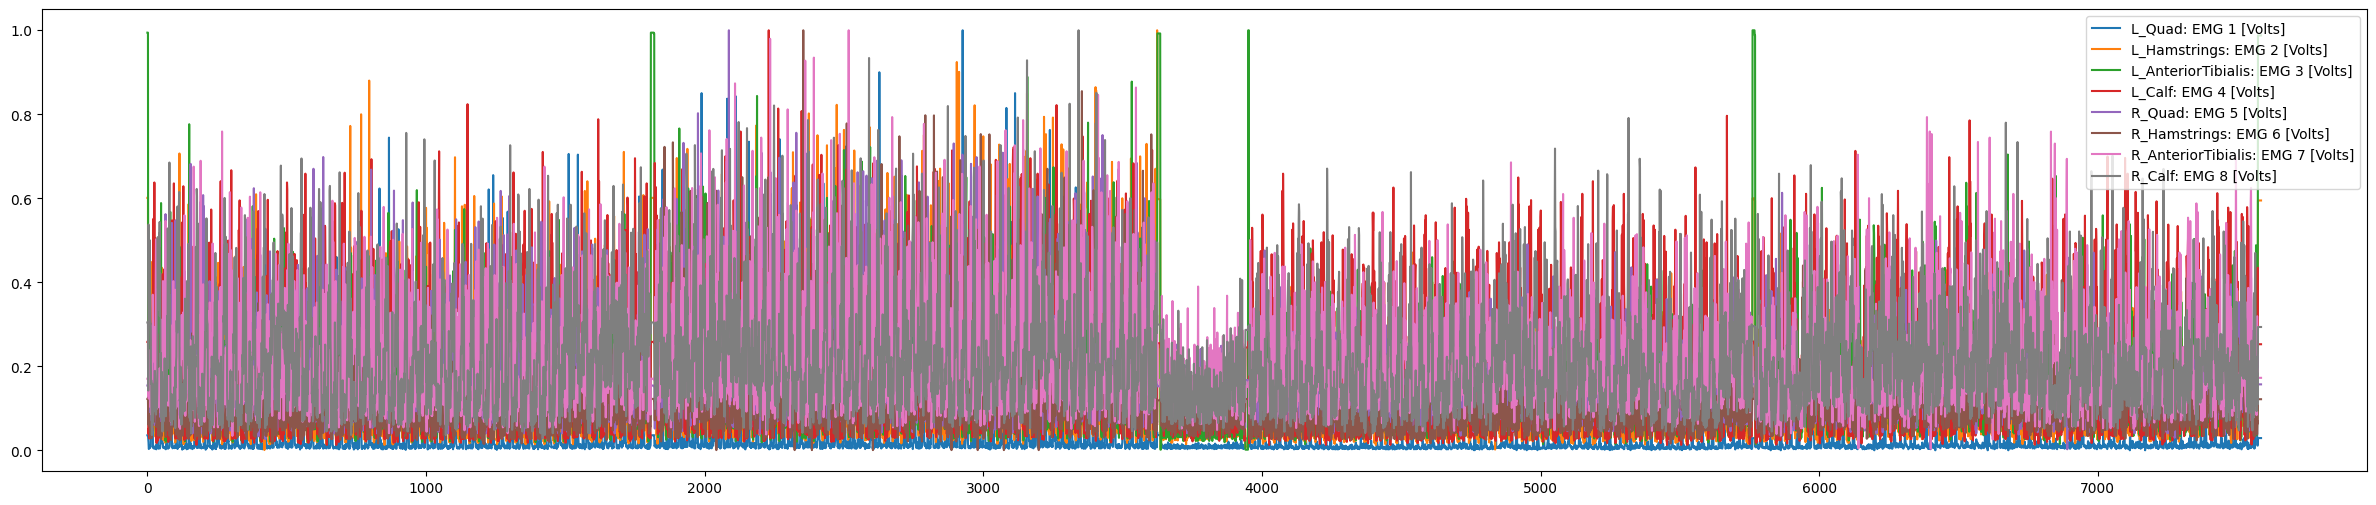

In [65]:
plt.figure(figsize=(30, 6), dpi=100)

plot_csv = new_csv.iloc[:, 0::4]
print(plot_csv.columns)

plt.plot(plot_csv.values)
plt.plot()
plt.legend(plot_csv.columns)

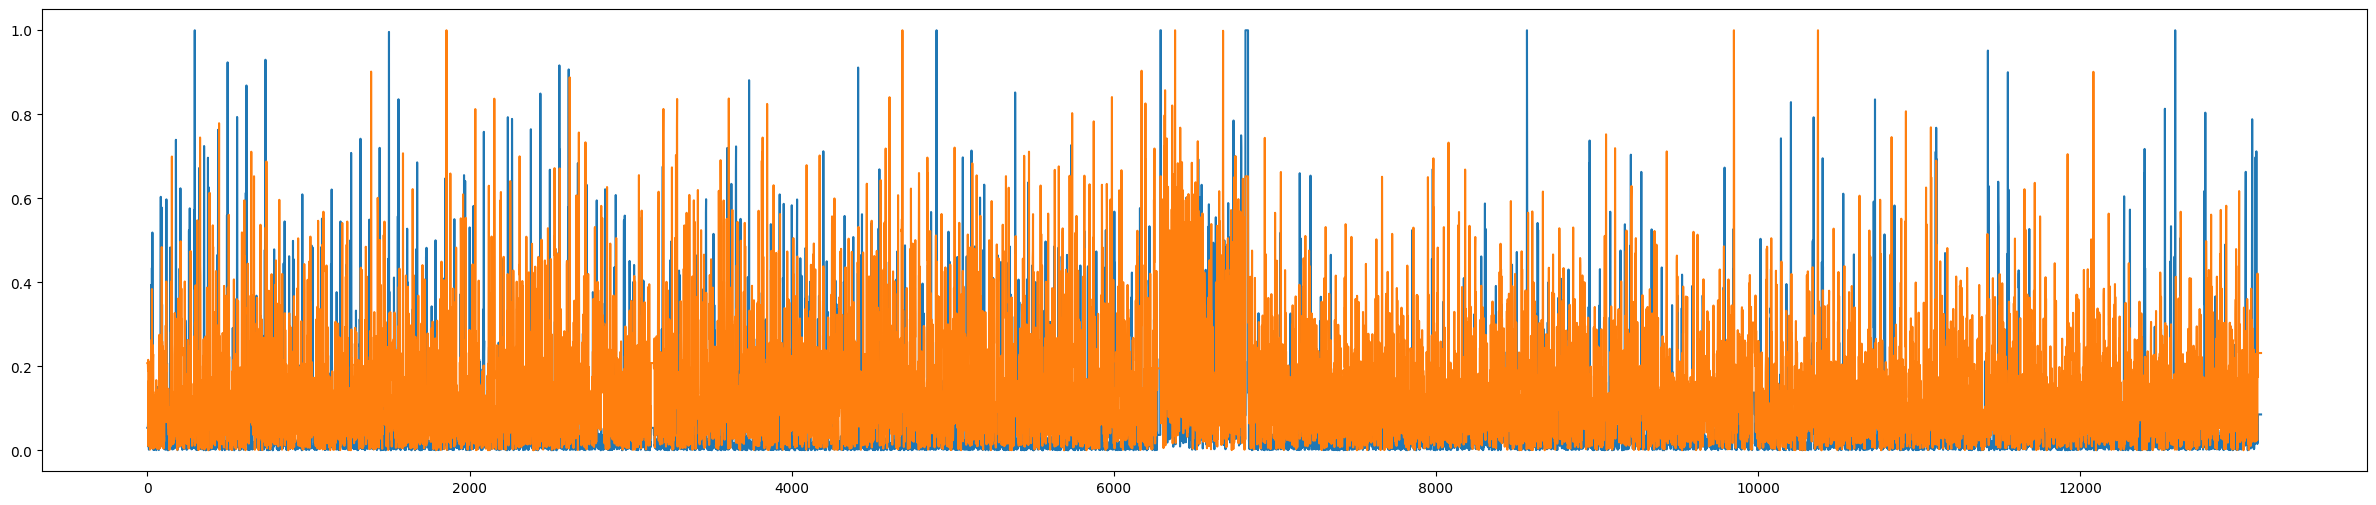

In [28]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[0]])
plt.plot(new_csv[list(new_csv.keys())[4]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[1]])
plt.plot(new_csv[list(new_csv.keys())[5]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[2]])
plt.plot(new_csv[list(new_csv.keys())[6]])

In [ ]:
plt.figure(figsize=(30, 6), dpi=100)
plt.plot(new_csv[list(new_csv.keys())[3]])
plt.plot(new_csv[list(new_csv.keys())[7]])